# Spotify Streaming History

In [1]:
!pip install spotipy
!pip install lyricsgenius

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import ast
from typing import List
from os import listdir
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
from spotipy import SpotifyOAuth, CacheFileHandler
import lyricsgenius as lg
import requests

In [2]:
url="https://raw.githubusercontent.com/danbm94/spotifyEDA/main/StreamingHistory0.json?token=AMNLDN74VPYBAX7YJEKEMYLATJ5A4"
music= pd.read_json("StreamingHistory0.json")
url1="https://raw.githubusercontent.com/danbm94/spotifyEDA/main/StreamingHistory1.json?token=AMNLDNYDY2HIC26J2NXD6XDATJ5C6"
music1=pd.read_json("StreamingHistory1.json")

In [4]:
df=music.append(music1)

In [5]:
df['endTime']=pd.to_datetime(df['endTime'],infer_datetime_format=True, errors='coerce')
cats=['artistName','trackName']
df[cats] = df[cats].astype('category')

In [6]:
df= df[df['msPlayed']>1000]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15069 entries, 0 to 5746
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   endTime     15069 non-null  datetime64[ns]
 1   artistName  15069 non-null  category      
 2   trackName   15069 non-null  category      
 3   msPlayed    15069 non-null  int64         
dtypes: category(2), datetime64[ns](1), int64(1)
memory usage: 663.7 KB


In [215]:
genius = lg.Genius('JSOKdC12oh_Ls6-G7VHnUyIpbHen9XNakCfiDPiOwS1CL9OevzOijj_COIcSBFbB', skip_non_songs=True, excluded_terms=["(Remix)", "(Live)"], remove_section_headers=True)

In [9]:
top50=df['artistName'].value_counts()

In [10]:
top50=top50[:50,]

In [15]:
df.loc[df['artistName']=="Radiohead"]

,endTime,artistName,trackName,msPlayed
138,2019-12-09 12:58:00,Radiohead,House Of Cards,328293
292,2019-12-11 07:58:00,Radiohead,Everything In Its Right Place,44483
320,2019-12-11 18:07:00,Radiohead,Karma Police - Remastered,261426
948,2019-12-25 12:44:00,Radiohead,House Of Cards,328293
955,2019-12-25 18:14:00,Radiohead,Everything In Its Right Place,248710
...,...,...,...,...
4992,2020-11-16 15:24:00,Radiohead,Go Slowly,228236
5170,2020-11-23 08:31:00,Radiohead,Palo Alto - Remastered,1126
5235,2020-11-24 16:51:00,Radiohead,The National Anthem,351693
5313,2020-11-27 10:46:00,Radiohead,Palo Alto - Remastered,231815


In [16]:
df['timesPlayed']=df['trackName'].map(df['trackName'].value_counts())

In [17]:
df['Year'] = pd.DatetimeIndex(df['endTime']).year
df['Month'] = pd.DatetimeIndex(df['endTime']).month

## Spotipy authorization

In [126]:
client_id= "3bd02289c7fc487f9f57235e393dc2fe"
client_secret= '194bc5d8f14b405d8d92fc2bee38c0fb'
username= "1196124016"
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) #spotify object to access API

In [127]:
scope = "user-library-read user-read-recently-played user-top-read playlist-modify-public playlist-read-private playlist-read-collaborative"
redirect_uri= "http://127.0.0.1:8080"

In [128]:
spotify = spotipy.Spotify(
    auth_manager=SpotifyOAuth(
        client_id=client_id,
        client_secret= client_secret,
        redirect_uri=redirect_uri,
        scope=scope,
        cache_handler=CacheFileHandler(username=username)
    )
)


In [129]:
def authenticate(redirect_uri, client_cred_manager, username, scope,client_id,client_secret):
    """
    Authenticates a user for a given spotify app.
    Parameters
    ----------
    redirect_uri : the redirect uri of the spotify app
    client_cred_manager : SpotifyClientCredentials containing client_id and client_secret
    username: spotify username
    scope: authorization scopes as a string
    client_id: spotify app client_id 
    client_secret: spotify app client_secret
    Returns
    -------
    sp: Spotify auth-token (SpotifyOAuth)
    """

    sp = spotipy.Spotify(client_credentials_manager = client_cred_manager)
    token = util.prompt_for_user_token(username, scope, client_id, client_secret, redirect_uri)
    
    if token:
        sp = spotipy.Spotify(auth=token)
    else:
        print("Can't get token for", username)
    return sp

In [130]:
token = util.prompt_for_user_token(username, scope, client_id, client_secret, redirect_uri)

In [131]:
authenticate(redirect_uri, client_credentials_manager, username,scope, client_id, client_secret)

In [11]:
def get_id(track_name: str, token: str) -> str:
    headers = {
        'Accept': 'application/json',
        'Content-Type': 'application/json',
        'Authorization': f'Bearer ' + token,
    }
    params = [
        ('q', track_name),
        ('type','track')
    ]
    try: 
        response = requests.get('https://api.spotify.com/v1/search', 
                    headers = headers, params = params, timeout = 5)
        json = response.json()
        first_result = json['tracks']['items'][0]
        track_id = first_result['id']
        return track_id
    except:
        return None


In [14]:
ibet = get_id("I Bet That You Look Good on the Dancefloor", token)
ibet

'0yMlW5eLp8T9E2u5BXuST2'

In [12]:
def get_features(track_id: str, token: str) -> dict:
    sp = spotipy.Spotify(auth=token)
    try:
        features = sp.audio_features([track_id])
        return features[0]
    except:
        return None

In [15]:
ibet_features= get_features(ibet, token)

In [22]:
ibet_features

{'danceability': 0.408,
 'energy': 0.628,
 'key': 0,
 'loudness': -5.992,
 'mode': 0,
 'speechiness': 0.0371,
 'acousticness': 0.283,
 'instrumentalness': 0,
 'liveness': 0.0457,
 'valence': 0.409,
 'tempo': 111.396,
 'type': 'audio_features',
 'id': '0yMlW5eLp8T9E2u5BXuST2',
 'uri': 'spotify:track:0yMlW5eLp8T9E2u5BXuST2',
 'track_href': 'https://api.spotify.com/v1/tracks/0yMlW5eLp8T9E2u5BXuST2',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/0yMlW5eLp8T9E2u5BXuST2',
 'duration_ms': 308310,
 'time_signature': 4}

In [18]:
def get_streamings() -> List[dict]:
    
    files = [x for x in listdir()
             if x.split('.')[0][:-1] == 'StreamingHistory']
    
    all_streamings = []
    
    for file in files: 
        with open(file, 'r', encoding='UTF-8') as f:
            new_streamings = ast.literal_eval(f.read())
            all_streamings += [streaming for streaming 
                               in new_streamings]
    return all_streamings

In [19]:
streamings = get_streamings()
unique_tracks = list(set([streaming['trackName'] 
                for streaming in streamings]))

all_features = {}
for track in unique_tracks:
    track_id = get_id(track, token)
    features = get_features(track_id, token)
    if features:
        all_features[track] = features
        
with_features = []
for track_name, features in all_features.items():
    with_features.append({'name': track_name, **features})

NameError: name 'get_features' is not defined

In [ ]:
music = pd.DataFrame(with_features)

In [67]:
music=music.rename(columns={"name":"trackName"})

In [68]:
df= pd.merge(df,music, on="trackName")

In [76]:
pink= df[df['artistName']=="Pink Floyd"]

In [191]:
import seaborn as sns

ModuleNotFoundError: No module named 'seaborn'

<AxesSubplot:xlabel='Month', ylabel='danceability'>

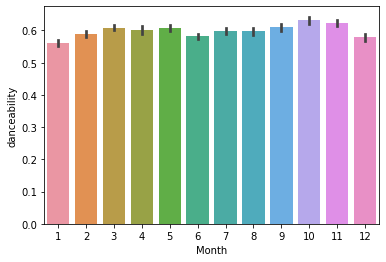

In [83]:
sns.barplot(x="Month",y="danceability",data=df)

In [85]:
df.describe(include="all", datetime_is_numeric=True)

,endTime,artistName,trackName,msPlayed,timesPlayed,Year,Month,danceability,energy,key,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
count,14895,14895,14895,1.489500e+04,14895.000000,14895.000000,14895.000000,14895.000000,14895.000000,14895.000000,...,14895.000000,14895.000000,14895.000000,14895,14895,14895,14895,14895,1.489500e+04,14895.000000
unique,NaN,2164,4943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,4856,4856,4856,4856,NaN,NaN
top,NaN,Arctic Monkeys,Yadnus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,audio_features,5zfg3qZOcjS4IFhazNk9PW,spotify:track:5zfg3qZOcjS4IFhazNk9PW,https://api.spotify.com/v1/tracks/5zfg3qZOcjS4...,https://api.spotify.com/v1/audio-analysis/5zfg...,NaN,NaN
freq,NaN,614,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,14895,63,63,63,63,NaN,NaN
mean,2020-05-21 09:09:17.011077632,NaN,NaN,1.962217e+05,14.757905,2019.926821,6.033434,0.594661,0.633176,5.358577,...,0.188859,0.521439,119.614206,NaN,NaN,NaN,NaN,NaN,2.403491e+05,3.920913
min,2019-12-06 23:48:00,NaN,NaN,1.002000e+03,1.000000,2019.000000,1.000000,0.000000,0.000050,0.000000,...,0.019700,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,1.282700e+04,0.000000
25%,2020-02-18 15:40:30,NaN,NaN,1.381690e+05,2.000000,2020.000000,3.000000,0.477000,0.492000,2.000000,...,0.092600,0.328000,99.024000,NaN,NaN,NaN,NaN,NaN,1.933550e+05,4.000000
50%,2020-05-29 13:54:00,NaN,NaN,2.101730e+05,6.000000,2020.000000,6.000000,0.608000,0.673000,5.000000,...,0.121000,0.528000,116.903000,NaN,NaN,NaN,NaN,NaN,2.247540e+05,4.000000
75%,2020-08-06 09:03:00,NaN,NaN,2.590265e+05,28.000000,2020.000000,9.000000,0.725000,0.804000,9.000000,...,0.236000,0.715000,135.811000,NaN,NaN,NaN,NaN,NaN,2.693530e+05,4.000000
max,2020-12-07 20:16:00,NaN,NaN,2.937129e+06,63.000000,2020.000000,12.000000,0.979000,0.999000,11.000000,...,0.989000,0.993000,215.572000,NaN,NaN,NaN,NaN,NaN,1.421455e+06,5.000000


In [72]:
#Save dataset to csv for further analysis
df.to_csv("music.csv")

In [17]:
df=pd.read_csv("music.csv",index_col= 0)

In [18]:
df= df.drop_duplicates(subset='trackName')

In [132]:
spotify.current_user_playlists()

{'href': 'https://api.spotify.com/v1/users/1196124016/playlists?offset=0&limit=50',
 'items': [{'collaborative': False,
   'description': 'A blend of music for Daniel and ninaesguay. Updates daily.',
   'external_urls': {'spotify': 'https://open.spotify.com/playlist/37i9dQZF1EJCl7vFyPfhnD'},
   'href': 'https://api.spotify.com/v1/playlists/37i9dQZF1EJCl7vFyPfhnD',
   'id': '37i9dQZF1EJCl7vFyPfhnD',
   'images': [{'height': None,
     'url': 'https://blend-playlist-covers.spotifycdn.com/v2/blend_LARGE-azure-pink-en.jpg',
     'width': None}],
   'name': 'ninaesguay + Daniel',
   'owner': {'display_name': 'Spotify',
    'external_urls': {'spotify': 'https://open.spotify.com/user/spotify'},
    'href': 'https://api.spotify.com/v1/users/spotify',
    'id': 'spotify',
    'type': 'user',
    'uri': 'spotify:user:spotify'},
   'primary_color': None,
   'public': False,
   'snapshot_id': 'MCwwMDAwMDAwMDBhZGU5NDM1ZmY3ODUzZjBlNTYwMGM0ZWE0MWE2M2Jm',
   'tracks': {'href': 'https://api.spotify.com

In [116]:
blend= spotify.playlist_items("37i9dQZF1EJCl7vFyPfhnD")
wrapped= spotify.playlist_items("37i9dQZF1EUMDoJuT8yJsl")

In [139]:
playlist=spotify.playlist_tracks(playlist_id="37i9dQZF1EJCl7vFyPfhnD", additional_types=('track',))

In [154]:
# Create empty dataframe
playlist_features_list = ["artist","album","track_name",  "track_id","danceability","energy","key","loudness","mode", "speechiness","instrumentalness","liveness","valence","tempo", "duration_ms","time_signature"]

playlist_df = pd.DataFrame(columns = playlist_features_list)


In [161]:
playlist1 = spotify.user_playlist_tracks(username, playlist_id="37i9dQZF1EJCl7vFyPfhnD")

In [168]:
def getTrackIDs(user, playlist_id):
    ids = []
    playlist = spotify.user_playlist(user, playlist_id)
    for item in playlist['tracks']['items']:
        track = item['track']
        ids.append(track['id'])
    return ids

ids = getTrackIDs(username, '37i9dQZF1EJCl7vFyPfhnD')

In [171]:
def getTrackFeatures(id):
  meta = spotify.track(id)
  features = spotify.audio_features(id)

  # meta
  name = meta['name']
  album = meta['album']['name']
  artist = meta['album']['artists'][0]['name']
  release_date = meta['album']['release_date']
  length = meta['duration_ms']
  popularity = meta['popularity']

  # features
  acousticness = features[0]['acousticness']
  danceability = features[0]['danceability']
  energy = features[0]['energy']
  instrumentalness = features[0]['instrumentalness']
  liveness = features[0]['liveness']
  loudness = features[0]['loudness']
  speechiness = features[0]['speechiness']
  tempo = features[0]['tempo']
  time_signature = features[0]['time_signature']

  track = [name, album, artist, release_date, length, popularity, danceability, acousticness, danceability, energy, instrumentalness, liveness, loudness, speechiness, tempo, time_signature]
  return track


In [174]:
import time
# loop over track ids 
tracks = []
for i in range(len(ids)):
  time.sleep(.5)
  track = getTrackFeatures(ids[i])
  tracks.append(track)

# create dataset
blend = pd.DataFrame(tracks, columns = ['name', 'album', 'artist', 'release_date', 'length', 'popularity', 'danceability', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature'])
#blend.to_csv("spotify.csv", sep = ',')

# Fetch lyrics for all songs

In [185]:
! pip3 install getlyrics

In [187]:
#import dependencies
import getlyrics


In [188]:
help(getlyrics)

Help on package getlyrics:

NAME
    getlyrics

PACKAGE CONTENTS
    __main__
    getlyrics

FILE
    /Users/daniel.bustillo/opt/anaconda3/envs/spotify/lib/python3.8/site-packages/getlyrics/__init__.py




## Using Genius

In [ ]:
def get_lyrics(ser, k):
    c = 0
    for name in ser:
        try:
            songs = (genius.search_artist(name, max_songs=k, sort='popularity')).songs
            s = [song.lyrics for song in songs]
            file.write("\n \n   <|endoftext|>   \n \n".join(s))
            c += 1
            print(f"Songs grabbed:{len(s)}")
        except:
            print(f"some exception at {name}: {c}")

In [200]:
lnda=genius.search_song(title="LA NOCHE DE ANOCHE",artist="BAD BUNNY")

Searching for "LA NOCHE DE ANOCHE" by BAD BUNNY...
Done.


In [201]:
lnda.lyrics

'Yo sé que esto no volverá a pasar\nPero si volviera a pasar, sé que sería tu debilidad\n\nPorque la noche de anoche fue\nAlgo que yo no puedo explicar\nEso era dando y dándole sin parar\nTú me decías que morías por mí\nPorque la noche de anoche fue (Eh-eh)\nAlgo que yo no puedo explicar (Eh-eh)\nEso era dando y dándole sin parar (Eh-eh)\nTú encima de mí, yo encima de ti (Oh-oh)\nEh, eh\n\nTú me dejaste el cuerpo caliente, infierno\nPero me dejaste el corazón frío, invierno\nSoñando que contigo e\' que duermo (Duermo)\nDime, papi\nDime, mami\n¿Esa noche quién la borra?\nTú me besaste y se me cayó la gorra\nSin mucha labia, sin mucha cotorra\nCuando \'toy contigo dejo que la vibra corra\nY que la luna no\' supervise\nCon esa boquita suena rico to\' lo que tú me dice\'\nHicimo\' pose\' que yo má\' nunca hice\nTú te mojaste\' pa\' que yo me bautice\nY me ponga serio, serio\nTú y yo junto\' creando un imperio\nEso\' ojito\' tienen un misterio\nPero al final na\' \'e lo nuestro fue en serio

In [216]:
from requests.exceptions import Timeout
lyrics=[]
genius.timeout=15
genius.sleep_time=40
for i, y in zip(blend['name'], blend['artist']):
   x= genius.search_song(title=i, artist=y)
   if x is not None:
      lyrics.append(x.lyrics)
   else:
      lyrics.append(np.nan)



Searching for "LA NOCHE DE ANOCHE" by Bad Bunny...
Done.
Searching for "Fire for You" by Cannons...
Done.
Searching for "Tiempo" by Ozuna...
Done.
Searching for "Inside of My Eyelids" by DLG....
Done.
Searching for "Lake Zurich" by Gorillaz...
Done.
Searching for "Busy Earnin'" by Jungle...
Done.
Searching for "Torre de Marfil" by Rufus T. Firefly...
Done.
Searching for "In a Mood" by TheSecondSex...
Done.
Searching for "Slide (feat. Frank Ocean & Migos)" by Calvin Harris...
Done.
Searching for "Best to You" by Blood Orange...
Done.
Searching for "Cold - Remix" by Maroon 5...
Done.
Searching for "Music Sounds Better with You" by NEIL FRANCES...
Done.
Searching for "Because You Move Me - Extended Mix" by Tinlicker...
No results found for: 'Because You Move Me - Extended Mix Tinlicker'
Searching for "Around The Sun" by Poolside...
Done.
Searching for "Oh My God" by Adele...
Done.
Searching for "Voodoo?" by L'Impératrice...
Done.
Searching for "Borderline" by Tame Impala...
Done.
Searchin

In [222]:
blend['lyrics'] = lyrics

In [224]:
blend.to_csv("spotify.csv", sep = ',')

# Preprocessing

In [3]:
import nltk
import re
from bs4 import BeautifulSoup

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

#And some packages as well
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/daniel.bustillo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/daniel.bustillo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/daniel.bustillo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/daniel.bustillo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
blend=pd.read_csv("spotify.csv", index_col=0)

In [5]:
blend['lyrics']=blend['lyrics'].fillna("")

In [7]:
blend


,name,album,artist,release_date,length,popularity,danceability,acousticness,danceability.1,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,lyrics
0,LA NOCHE DE ANOCHE,EL ÚLTIMO TOUR DEL MUNDO,Bad Bunny,2020-11-27,203200,87,0.856,0.030300,0.856,0.618,0.000000,0.0866,-4.892,0.2860,81.993,4,Yo sé que esto no volverá a pasar\nPero si vol...
1,Fire for You,Shadows,Cannons,2019-07-12,231825,75,0.737,0.114000,0.737,0.678,0.157000,0.1230,-7.011,0.0962,102.051,4,I was on fire for you\nWhere did you go?\nI co...
2,Tiempo,Tiempo,Ozuna,2021-05-06,171813,71,0.778,0.250000,0.778,0.752,0.003860,0.0866,-4.976,0.1490,180.017,4,"Woh-oh-oh-oh-oh-oh, jajaja\nWoh-oh-oh-oh-oh-oh..."
3,Inside of My Eyelids,Inside of My Eyelids,DLG.,2020-01-10,228891,60,0.730,0.677000,0.730,0.305,0.000072,0.1440,-13.371,0.4920,99.095,4,I get this feeling\nI can't fight it\nJust lik...
4,Lake Zurich,The Now Now,Gorillaz,2018-06-29,253626,56,0.618,0.000108,0.618,0.886,0.881000,0.0821,-6.099,0.0330,115.082,4,Last chance to buy before you fly\nLast chance...
5,Busy Earnin',Jungle,Jungle,2014-07-14,181772,66,0.552,0.209000,0.552,0.883,0.000005,0.0912,-5.610,0.0355,99.967,4,"So you've come a long way\n(Huh, woo-hoo)\nBut..."
6,Torre de Marfil,Torre de Marfil,Rufus T. Firefly,2021-05-21,280037,41,0.204,0.032300,0.204,0.599,0.177000,0.1160,-10.124,0.1290,173.791,4,Tú eres mi casa\nEl bálsamo del amanecer\nNo t...
7,In a Mood,In a Mood,TheSecondSex,2017-10-21,247500,52,0.761,0.523000,0.761,0.293,0.721000,0.1240,-19.087,0.0452,143.976,4,I wanna be happy\nBut I can’t\n‘cause I’m in a...
8,Slide (feat. Frank Ocean & Migos),Funk Wav Bounces Vol.1,Calvin Harris,2017-06-30,230813,69,0.736,0.498000,0.736,0.795,0.000001,0.2540,-3.299,0.0545,104.066,4,"Ranking has ended, so this page is no longer i..."
9,Best to You,Freetown Sound,Blood Orange,2016-06-28,225747,59,0.658,0.181000,0.658,0.785,0.002230,0.7240,-8.513,0.0360,125.015,4,Call it all for nothing\nBut I'd rather be not...


In [8]:
# Lemmatize with POS Tag
def get_wordnet_pos(word):
    """Map POS tag to first character for lemmatization"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [9]:
#Create a function to clean the articles from html,  non alphanumerical carachters and stopwords
def clean_song(df):
  cleaned_text=[]
  lemmatizer= WordNetLemmatizer()
  print('Cleaning {} songs'. format(df.shape[0]))
  counter= 0
  for song in df:
    #remove html tags
    song_lyric = BeautifulSoup(song).get_text()
    song_lyric = song_lyric.lower()
    song_lyric = re.sub("\n"," ",song_lyric)
    song_lyric = re.sub("http\S+"," ",song_lyric)
    song_lyric = re.sub("www\S+"," ",song_lyric)
    song_lyric = re.sub("urlcopyembedcopy"," ",song_lyric)
    song_lyric = re.sub("oh"," ",song_lyric)
    song_lyric = re.sub("eh"," ",song_lyric)
    song_lyric = re.sub("embedshare"," ",song_lyric)
    
    
    song_lyric=song_lyric.lstrip()
    song_lyric=re.sub("\s{2,}"," ",song_lyric)

    #remove non alphabetic strings
    song_lyric = re.sub("[^a-zA-Z]"," ",song_lyric)

    #tokenize the sentences
    words = word_tokenize(song_lyric)

    #filter stopwords
    words = [w for w in words if w not in stopwords.words('english')]
    words = [w for w in words if w not in stopwords.words('spanish')]
    words = [w for w in words if w not in stopwords.words('german')]

    #Lemmatize each word
    lemma_words = [lemmatizer.lemmatize(i, get_wordnet_pos(i)) for i in words]
    cleaned_text.append(lemma_words)

    if (counter>0 and counter %500==0):
      print("Processed {} songs.". format(counter))

    counter+= 1
  print("Done")
  return (cleaned_text)

In [10]:
cleaned_lyrics= clean_song(blend['lyrics'])

Cleaning 50 songs
Done


In [12]:
type(cleaned_lyrics)

list

In [13]:
from wordcloud import WordCloud, STOPWORDS 


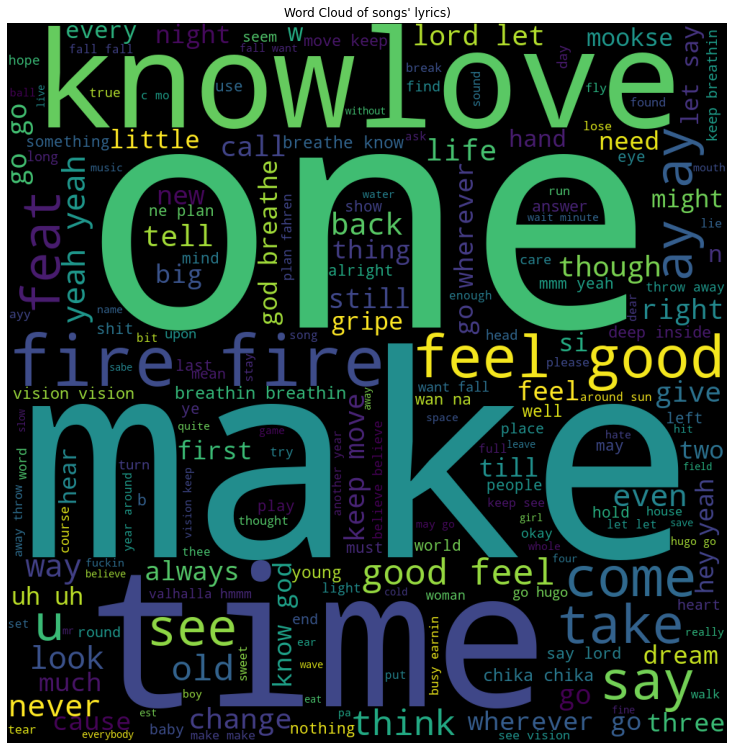

In [14]:
comment_words = '' 
stopwords = set(STOPWORDS) 
for i in cleaned_lyrics:
    comment_words+= ' '.join(i)+" "

wordcloud = WordCloud(width = 1000, height = 1000, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 



# plot the WordCloud image                        
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Word Cloud of songs' lyrics)")  
plt.show() 

In [15]:

#Word2vec
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

/Users/daniel.bustillo/opt/anaconda3/envs/spotify/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [16]:
model= Word2Vec(cleaned_lyrics, vector_size=100, window=20, min_count=1)

In [17]:
for index, word in enumerate(model.wv.index_to_key):
    if index == 10:
        break
    print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")

word #0/7222 is go
word #1/7222 is like
word #2/7222 is yeah
word #3/7222 is get
word #4/7222 is feel
word #5/7222 is know
word #6/7222 is one
word #7/7222 is make
word #8/7222 is say
word #9/7222 is let


In [38]:

model.wv.key_to_index["game"]

222

In [19]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.key_to_index:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [20]:
tsne_plot(model)

TypeError: 'Word2Vec' object is not subscriptable

In [334]:
from gensim.test.utils import common_texts

In [336]:
model=Word2Vec(sentences=common_texts, vector_size=100, window=5,min_count=1)

In [338]:
model.wv.most_similar("graph")

[('user', 0.06793875992298126),
 ('survey', 0.03364057093858719),
 ('eps', 0.009391184896230698),
 ('human', 0.00831596553325653),
 ('minors', 0.004503015894442797),
 ('system', -0.010839187540113926),
 ('trees', -0.023671669885516167),
 ('computer', -0.09575346857309341),
 ('time', -0.11410722136497498),
 ('response', -0.11557209491729736)]

# Create Dashboard with DASH

In [29]:
!pip install dash

     |████████████████████████████████| 77 kB 3.3 MB/s eta 0:00:011
  Using cached Flask_Compress-1.9.0-py3-none-any.whl (7.3 kB)
  Using cached plotly-4.14.3-py2.py3-none-any.whl (13.2 MB)
     |████████████████████████████████| 1.0 MB 6.0 MB/s eta 0:00:01
     |████████████████████████████████| 3.5 MB 10.5 MB/s eta 0:00:01
     |████████████████████████████████| 82 kB 1.9 MB/s  eta 0:00:01
     |████████████████████████████████| 1.8 MB 23.3 MB/s eta 0:00:01
  Using cached Brotli-1.0.9-cp37-cp37m-macosx_10_9_x86_64.whl (421 kB)
  Using cached retrying-1.3.3.tar.gz (10 kB)
  Created wheel for dash: filename=dash-1.20.0-py3-none-any.whl size=85831 sha256=00b7cb875578d8c2feef8aec9c31803550ab36a2ace8f86608a54564348120b8
  Stored in directory: /Users/daniel.bustillo/Library/Caches/pip/wheels/4f/c3/6a/a7cb9cedfdf93e0f0e8db0817ff2646d319afa9e4ca543ef9c
  Created wheel for dash-core-components: filename=dash_core_components-1.16.0-py3-none-any.whl size=3540991 sha256=1886c3754245823d5eabbb8e6

In [40]:
import dash
import dash_core_components as dcc
import dash_html_components as html

In [41]:
app = dash.Dash(__name__)

In [44]:
app.layout = html.Div(
    children=[
        html.H1(children="Music Dashboards",),
        html.P(
            children="Analyze the behavior of music "
            " and the artist"
            " between 2019 and 2020",
        ),
        dcc.Graph(
            figure={
                "data": [
                    {
                        "x": blend["artist"],
                        "y": blend["danceability"],
                        "type": "lines",
                    },
                ],
                "layout": {"title": "Average danceability "},
            },
        ),
        dcc.Graph(
            figure={
                "data": [
                    {
                        "x": blend["artist"],
                        "y": blend["danceability"],
                        "type": "lines",
                    },
                ],
                "layout": {"title": "danceability"},
            },
        ),
    ]
)

In [45]:
if __name__ == "__main__":
    app.run_server(debug=True)

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


/Users/daniel.bustillo/opt/anaconda3/envs/spotify/lib/python3.8/site-packages/traitlets/traitlets.py:2202: FutureWarning: Supporting extra quotes around strings is deprecated in traitlets 5.0. You can use 'hmac-sha256' instead of '"hmac-sha256"' if you require traitlets >=5.
  warn(
/Users/daniel.bustillo/opt/anaconda3/envs/spotify/lib/python3.8/site-packages/traitlets/traitlets.py:2157: FutureWarning: Supporting extra quotes around Bytes is deprecated in traitlets 5.0. Use 'b0dcb92d-e7d7-4be5-927d-6855c39ea207' instead of 'b"b0dcb92d-e7d7-4be5-927d-6855c39ea207"'.
  warn(
Traceback (most recent call last):
  File "/Users/daniel.bustillo/opt/anaconda3/envs/spotify/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/daniel.bustillo/opt/anaconda3/envs/spotify/lib/python3.8/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.initialize(argv)
  File "/Users/daniel.bustillo/opt/anaconda3/envs/

SystemExit: 1

/Users/daniel.bustillo/opt/anaconda3/envs/spotify/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3449: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
